In [1]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools',
    'ggpubr',
    'fst',
    'FPML'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

Loaded glmnet 2.0-12


Attaching package: ‘dplyr’

The following object is masked from ‘package:xgboost’:

    slice

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:glmnet’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



[1] "FPML"         "fst"          "ggpubr"       "magrittr"     "caTools"     
 [6] "caret"        "lattice"      "stringr"      "ROCR"         "gplots"      
[11] "pROC"         "tidyr"        "dplyr"        "glmnet"       "foreach"     
[16] "Matrix"       "xgboost"      "ggplot2"      "RColorBrewer" "stats"       
[21] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[26] "base"

Loading required package: DBI
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:pROC’:

    var

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

# Data Preparation

We're going to load a number of things here:

1. The ChIPseq hit data itself (for making the TF-motif map)
2. The motif-class mapping (extdata file)
3. Our annotated data set of ChipSeq positive/negative hits

In [6]:
load(system.file(package="FPML", "extdata/motif_class_pairs.Rdata"))

In [5]:
# Read the ChIPseq data from the local database                                                                                                
    db.chipseq <- DBI::dbConnect(drv=RPostgreSQL::PostgreSQL(),
                                 user = "trena",
                                 password = "trena",
                                 dbname = "chipseq",
                                 host= "localhost")

    # Grab the hits table as is                                                                                                                    
    chipseq.hits <- DBI::dbGetQuery(db.chipseq, "select * from hits")
    chipseq.hits <- tibble::as_tibble(chipseq.hits)

    # Grab the regions table and modify the chrom column                                                                                           
    chipseq.regions <- DBI::dbGetQuery(db.chipseq, "select * from regions")
    chipseq.regions <- tibble::as_tibble(chipseq.regions)
    chr.list <- chipseq.regions$chrom
    cutoff <- nchar("chr")+1
    no.chr.list <- substring(chr.list,cutoff)
    chipseq.regions$chrom <- no.chr.list

    # Create the TF-Motif mapping using the correct function                                                                                       
    TFs.to.motifs <- mapTFsToMotifs(chipseq.hits)

Update: load the 2 annotated data sets (they're .fst files) and join them; note that these are from fst_0.7.2; thus, they're "old format" and we have to add that flag.

In [3]:
annotated.16 <- read.fst("/ssd/mrichard//data/annotated.16.20mil.fst", old_format = TRUE)
annotated.20 <- read.fst("/ssd/mrichard//data/annotated.20.20mil.fst", old_format = TRUE)

Warning message in fstretrieve(fileName, columns, from, to, old_format):
“This fst file was created with a beta version of the fst package. Please re-write the data as this format will not be supported in future releases.”Warning message in fstretrieve(fileName, columns, from, to, old_format):
“This fst file was created with a beta version of the fst package. Please re-write the data as this format will not be supported in future releases.”

In [7]:
joined.df <- joinModelData(full.16 = annotated.16, full.20 = annotated.20)

Let's quickly take a look at what we're dealing with here, just to get an idea of scope:

In [8]:
str(joined.df)

'data.frame':	19999910 obs. of  43 variables:
 $ motifname                               : chr  "Hsapiens-jaspar2016-KLF16-MA0741.1" "Hsapiens-jaspar2016-E2F3-MA0469.2" "Hsapiens-jaspar2016-NR2C2-MA0504.1" "Hsapiens-jaspar2016-SP1-MA0079.3" ...
 $ chrom                                   : chr  "1" "1" "1" "1" ...
 $ strand                                  : chr  "-" "-" "+" "-" ...
 $ motifscore                              : num  9.98 6.45 10.21 11.88 9.27 ...
 $ loc                                     : chr  "chr1:121689787-121689797" "chr1:82852704-82852721" "chr1:34175253-34175267" "chr1:154975621-154975631" ...
 $ cs_hit                                  : num  0 0 0 1 0 0 0 0 0 0 ...
 $ h_max_score_20                          : num  0 0 15 11 0 0 0 12 0 0 ...
 $ h_percent_overlap_20                    : num  0 0 14.3 100 0 ...
 $ w_min_score_20                          : num  0 0 -8.62 -9.16 0 ...
 $ w_percent_overlap_20                    : num  0 0 71.4 100 0 ...
 $ h_frac_20   

Remove all info about class, which we won't care about when talking about an individual TF

In [11]:
to_discard <- intersect(motif.class$class, colnames(joined.df))

# Add in the other columns we discard
to_discard <- c(to_discard, "strand", "loc")

joined.df %>% select(-one_of(to_discard)) ->
    df_cols_selected

In [14]:
head(df_cols_selected)

motifname,chrom,motifscore,cs_hit,h_max_score_20,h_percent_overlap_20,w_min_score_20,w_percent_overlap_20,h_frac_20,w_frac_20,gc_content,asinh_tss_dist,h_max_score_16,h_percent_overlap_16,w_min_score_16,w_percent_overlap_16,h_frac_16,w_frac_16
Hsapiens-jaspar2016-KLF16-MA0741.1,1,9.97753,0,0,0.00000,0.00000,0.00000,0.00000000,0.00000000,0.4179104,13.823969,0,0.00000,0.00000,0.00000,0.00000000,0.00000000
Hsapiens-jaspar2016-E2F3-MA0469.2,1,6.44944,0,0,0.00000,0.00000,0.00000,0.00000000,0.00000000,0.3482587,14.645309,0,0.00000,0.00000,0.00000,0.00000000,0.00000000
Hsapiens-jaspar2016-NR2C2-MA0504.1,1,10.21110,0,15,14.28571,-8.62394,71.42857,0.02173913,0.06666667,0.4875622,9.725437,15,14.28571,-8.62394,71.42857,0.02272727,0.04166667
Hsapiens-jaspar2016-SP1-MA0079.3,1,11.87640,1,11,100.00000,-9.16294,100.00000,0.04347826,0.06666667,0.6218905,7.567346,58,90.00000,-6.95362,40.00000,0.04545455,0.04166667
Hsapiens-jaspar2016-RARA::RXRA-MA0159.1,1,9.26966,0,0,0.00000,0.00000,0.00000,0.00000000,0.00000000,0.4825871,12.686719,0,0.00000,0.00000,0.00000,0.00000000,0.00000000
Hsapiens-jaspar2016-CEBPA-MA0102.3,1,11.00000,0,0,0.00000,0.00000,0.00000,0.00000000,0.00000000,0.4626866,12.274861,0,0.00000,0.00000,0.00000,0.00000000,0.00000000


This constitutes our starting set of information. Now we'll split into training/testing/validation sets. We don't expect chromosome to have an effect on the results, so this gives us an easy way to split.

ALSO, we bias at a 10:1 ratio:

In [15]:
df_cols_selected %>%
    filter(chrom %in% c("2","4")) %>%
    select(-chrom) ->
    val_df

df_cols_selected %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-chrom) ->
    test_df

# Create the 10:1 bias
df_cols_selected %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) ->
    train.init

This takes longer...

In [17]:
train.list <- lapply(unique(train.init$motifname),
                     createBiasOneMotif,
                     train.df = train.init,
                     negPosRatio = 10)

In [18]:
train.list %>% bind_rows() %>%
    select(-chrom) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits)

dim(train_df); dim(test_df);

Warning message in remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits):
“object 'all.TF.df.fimo.hint.well.annotated' not found”Warning message in remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits):
“object 'df_only_footprint_hits' not found”

[1] 1240624      17

[1] 4110502      17

# Transcription Factor Selection

Our goal is to look at how motif choice affects prediction accuracy within one TF; to accomplish this, it makes sense to find a transcription factor with a large number of motifs. We'll determine this using our mapping, grouping our motifs together by TF and then counting to figure out which TF has the highest number. We'll also plot the motif/TF relationship just to illustrate what it looks like.

First, let's see what the mapping looks like:

In [19]:
head(TFs.to.motifs)

$ATF2
[1] "Ggallus-jaspar2016-MAFG::NFE2L1-MA0089.1" 
[2] "Hsapiens-jaspar2016-ATF7-MA0834.1"        
[3] "Hsapiens-jaspar2016-JUNB-MA0490.1"        
[4] "Hsapiens-jaspar2016-JUND-MA0491.1"        
[5] "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" 
[6] "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1"
[7] "Mmusculus-jaspar2016-Creb5-MA0840.1"      
[8] "Mmusculus-jaspar2016-Nfe2l2-MA0150.2"     

$ATF3
[1] "Hsapiens-jaspar2016-JDP2-MA0655.1"       
[2] "Hsapiens-jaspar2016-JDP2(var.2)-MA0656.1"
[3] "Mmusculus-jaspar2016-Atf3-MA0605.1"      

$BATF
[1] "Hsapiens-jaspar2016-BATF::JUN-MA0462.1" 
[2] "Hsapiens-jaspar2016-BATF3-MA0835.1"     
[3] "Hsapiens-jaspar2016-JUN(var.2)-MA0489.1"

$BCL11A
[1] "Hsapiens-jaspar2016-RUNX2-MA0511.1"  "Mmusculus-jaspar2016-RUNX1-MA0002.2"

$BHLHE40
[1] "Hsapiens-jaspar2016-BHLHE40-MA0464.2"
[2] "Hsapiens-jaspar2016-MAX-MA0058.3"    
[3] "Hsapiens-jaspar2016-MNT-MA0825.1"    
[4] "Mmusculus-jaspar2016-Myc-MA0147.1"   
[5] "Mmusculus-jaspar2016-Npas2-MA0626.1" 

$CEBPB
[1] "Hsapiens-jaspar2016-CEBPA-MA0102.3" "Hsapiens-jaspar2016-CEBPB-MA0466.1"
[3] "Hsapiens-jaspar2016-CEBPB-MA0466.2"

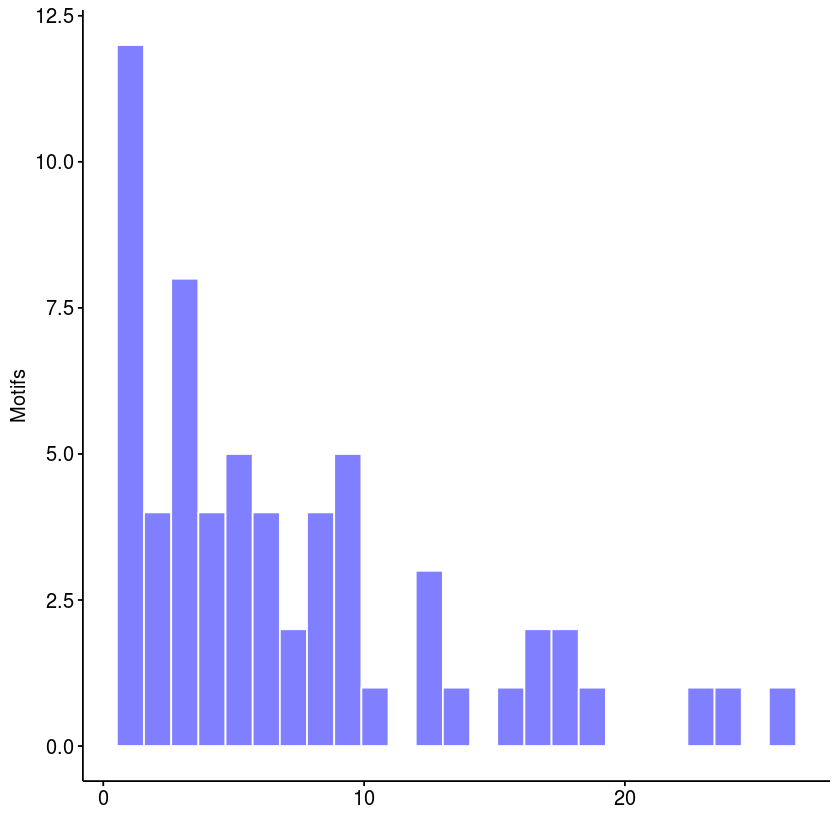

In [20]:
sapply(TFs.to.motifs, length) %>% gghistogram(fill = "blue", 
                                              color = "white",
                                              xlab = "",
                                              ylab = "Motifs",
                                              bins = 25
                                             )

As we can see, the vast majority of TFs have fewer than 10 motifs; however, a few have over 20. Let us grab the top TF, which should give us our best candidate

In [21]:
TF.sums <- sapply(TFs.to.motifs, length) 
top.TF <- names(TF.sums)[which(TF.sums == max(TF.sums))]
TF.sums[top.TF]

ELF1 
  26

# Model Training

We'll narrow our data frame down to the motifs that correspond to this TF, then we'll train a model on each of these motifs individually


In [22]:
only.my.motifs <- TFs.to.motifs[[top.TF]]
train_df %>% filter(motifname %in% only.my.motifs) -> train_df
test_df %>% filter(motifname %in% only.my.motifs) -> test_df

dim(train_df); dim(test_df)

[1] 137500     17

[1] 226449     17

In [29]:
all_stats_df <- data.frame()

for (motif in only.my.motifs) {
    
    # filter down to only the relevant motif
    train_df %>%
        filter(motifname == motif) ->
        this_motif_train_df
    test_df %>%
        filter(motifname == motif) ->
        this_motif_test_df
    
    # make training and testing data sets
    X_train_this_motif <- as.matrix(select(this_motif_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_motif <- this_motif_train_df$cs_hit
    X_test_this_motif <- as.matrix(select(this_motif_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_motif <- this_motif_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_motif <- xgboost(
        params = param,
        data = X_train_this_motif,
        label = y_train_this_motif,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    
    # Name it with the short motif name
    short.motif <- gsub(".+(MA\\d{4}\\.\\d).*","\\1",motif)
    gbdt_motif$Model.Name <- short.motif
    
    
    # gather statistics for model on this TF
    this_motif_pred_df <- make.pred.df.from.model(gbdt_motif, X_test_this_motif, y_test_this_motif)
    colnames(this_motif_pred_df)[1] <- "ChIPseq.bound"
    this_motif_stat_df <- make.stats.df.from.preds(this_motif_pred_df)
    this_motif_stat_df$Train.Samples <- length(y_train_this_motif)
    this_motif_stat_df$Test.Samples <- length(y_test_this_motif)
    
    # save stats
    all_stats_df <- rbind(all_stats_df, this_motif_stat_df)

}

In [30]:
str(all_stats_df)

'data.frame':	2626 obs. of  10 variables:
 $ threshold    : num  0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 ...
 $ sensitivity  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ specificity  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ppv          : num  0.017 0.017 0.017 0.017 0.017 ...
 $ npv          : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ accuracy     : num  0.017 0.017 0.017 0.017 0.017 ...
 $ MattCC       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Model.Name   : chr  "MA0598.2" "MA0598.2" "MA0598.2" "MA0598.2" ...
 $ Train.Samples: int  4994 4994 4994 4994 4994 4994 4994 4994 4994 4994 ...
 $ Test.Samples : int  7185 7185 7185 7185 7185 7185 7185 7185 7185 7185 ...


In [31]:
# Save the stats to a file
save(all_stats_df, file = "./per_TF_output/per_motif_stats.Rdata")

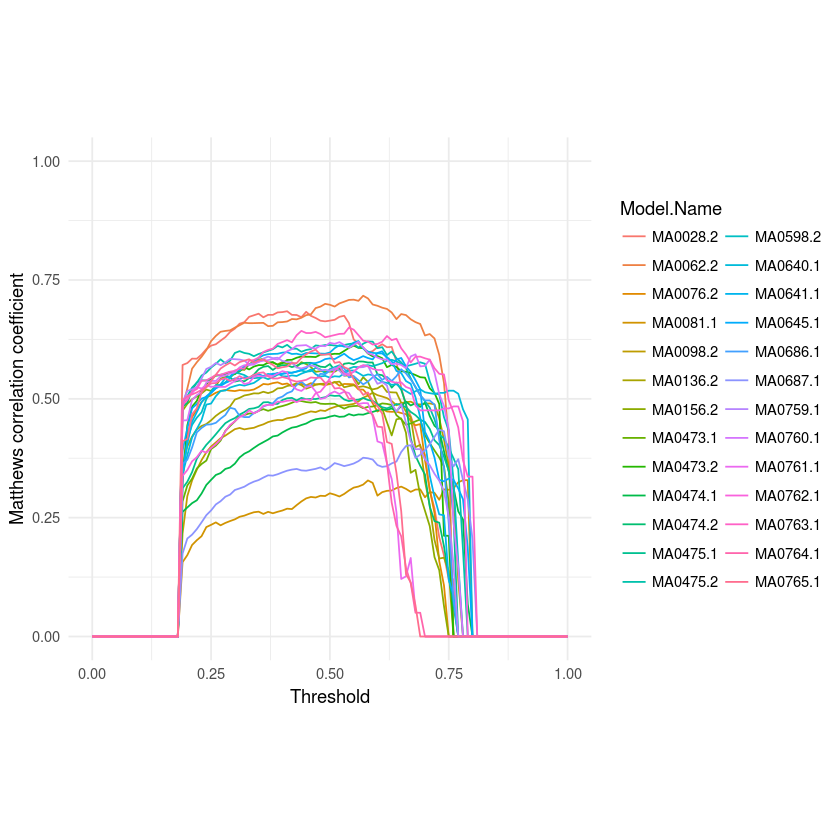

In [32]:
plot.mattcc.curve(all_stats_df) + theme_minimal()

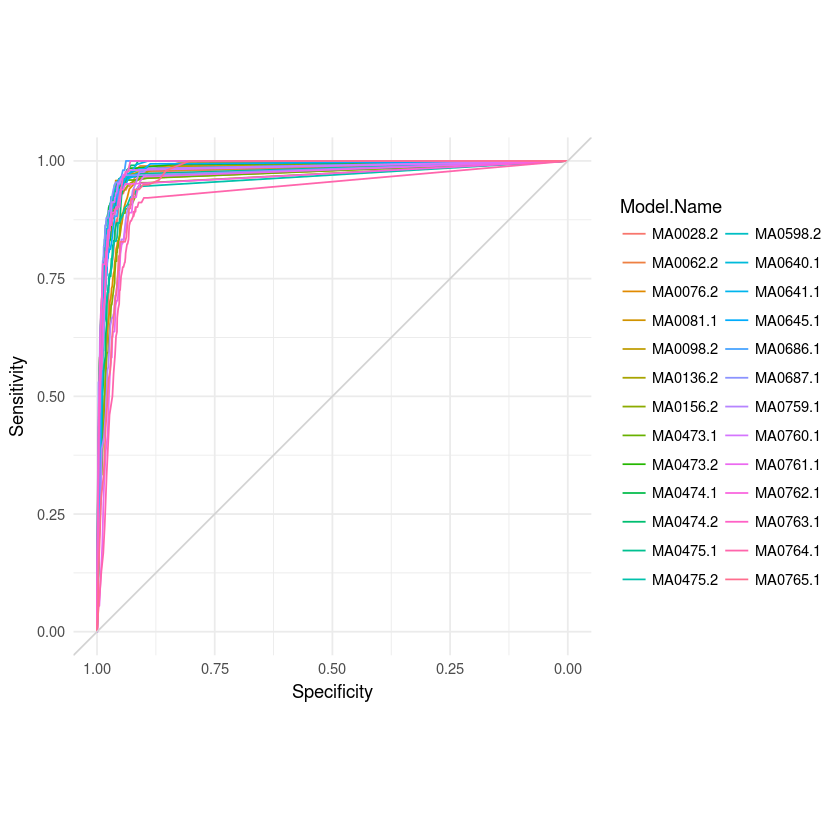

In [33]:
plot.roc.curve(all_stats_df) + theme_minimal()

Warning message:
“Removed 596 rows containing missing values (geom_path).”

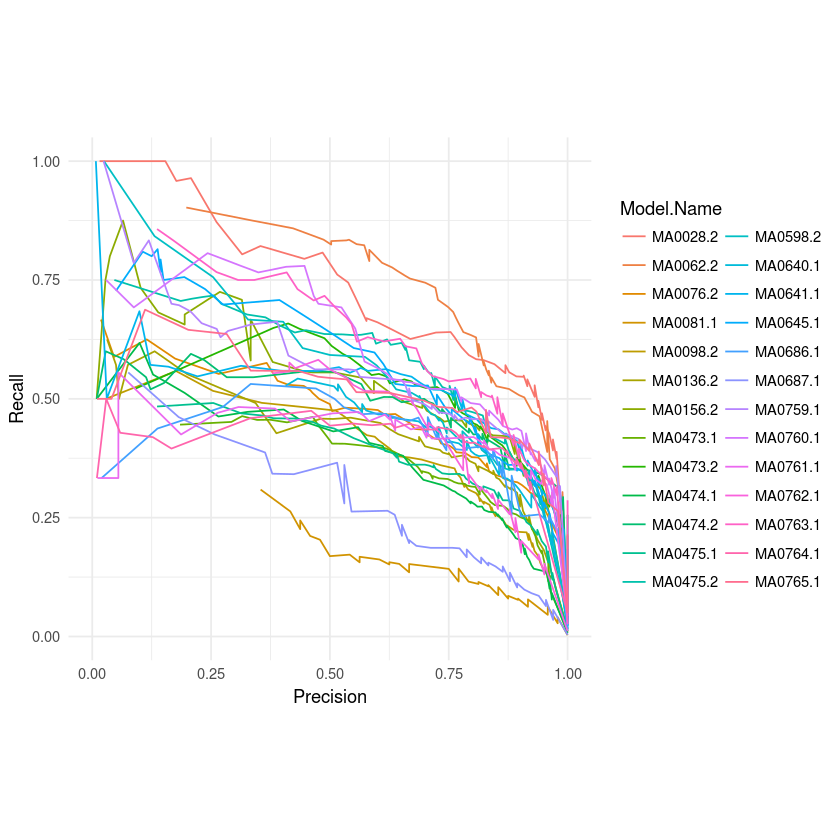

In [34]:
plot.precrecall.curve(all_stats_df) + theme_minimal()

# END OF MOTIF CLASSIFIER

Below is scraps from another notebook; pay them no mind

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`


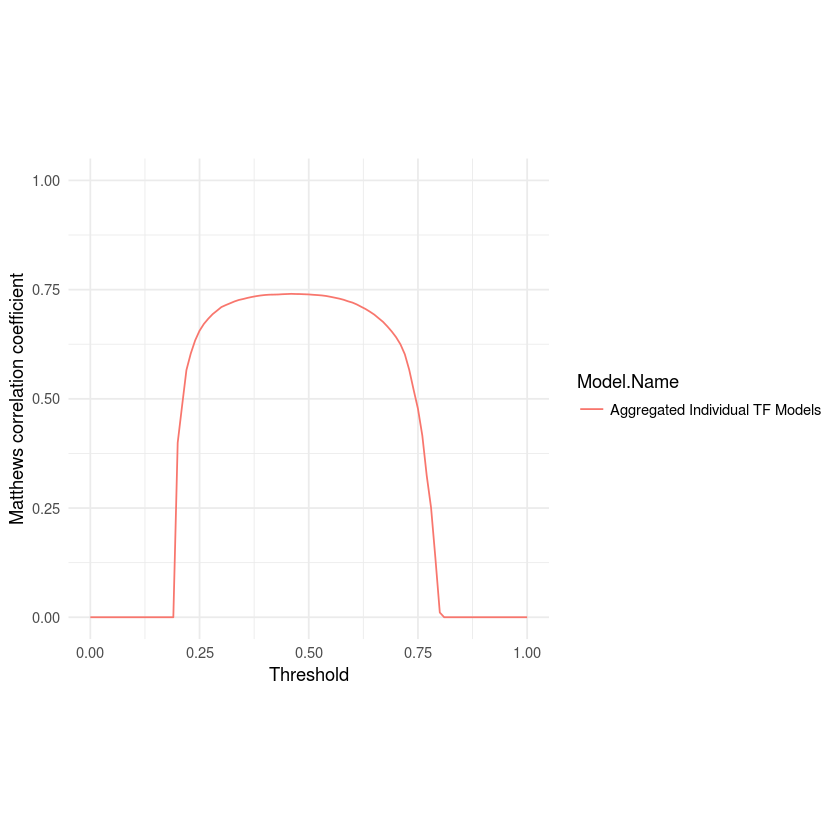

In [57]:
all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") %>%
    plot.mattcc.curve

In [58]:
all_stats_motif_df <- data.frame()

motifs <- unique(train_df$motifname) %>% intersect(unique(test_df$motifname))
for (motif in motifs) {
    
    # filter down to only relevant motifs
    train_df %>%
        filter(motifname == motif) ->
        this_motif_train_df
    test_df %>%
        filter(motifname == motif) ->
        this_motif_test_df
    
    # make training and testing data sets
    X_train_this_motif <- as.matrix(select(this_motif_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_motif <- this_motif_train_df$cs_hit
    X_test_this_motif <- as.matrix(select(this_motif_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_motif <- this_motif_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_motif <- xgboost(
        params = param,
        data = X_train_this_motif,
        label = y_train_this_motif,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    gbdt_motif$Model.Name <- motif
    
    
    # gather statistics for model on this motif
    this_motif_pred_df <- make.pred.df.from.model(gbdt_motif, X_test_this_motif, y_test_this_motif)
    colnames(this_motif_pred_df)[1] <- "ChIPseq.bound"
    this_motif_stat_df <- make.stats.df.from.preds(this_motif_pred_df)
    this_motif_stat_df$Train.Samples <- length(y_train_this_motif)
    this_motif_stat_df$Test.Samples <- length(y_test_this_motif)
    
    # save stats
    all_stats_motif_df <- rbind(all_stats_motif_df, this_motif_stat_df)

}

In [59]:
load(file="per_TF_output/all_together_tree_stats.Rdata")
medium_stat_df$Model.Name <- "All together Trees with Classes"

In [60]:
all_stats_motif_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual Motif Models") ->
    aggreagate_stats_motif_df

all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") ->
    aggreagate_stats_TF_df

compare_methods_df <- rbind(aggreagate_stats_motif_df, aggreagate_stats_TF_df, medium_stat_df)

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`
`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`


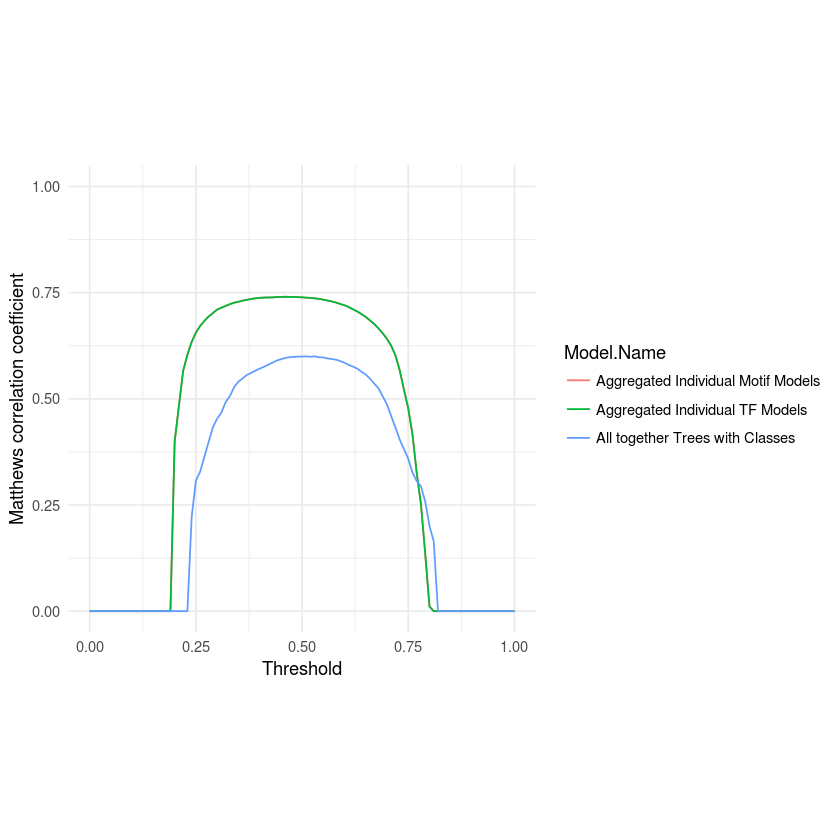

In [61]:
plot.mattcc.curve(compare_methods_df)

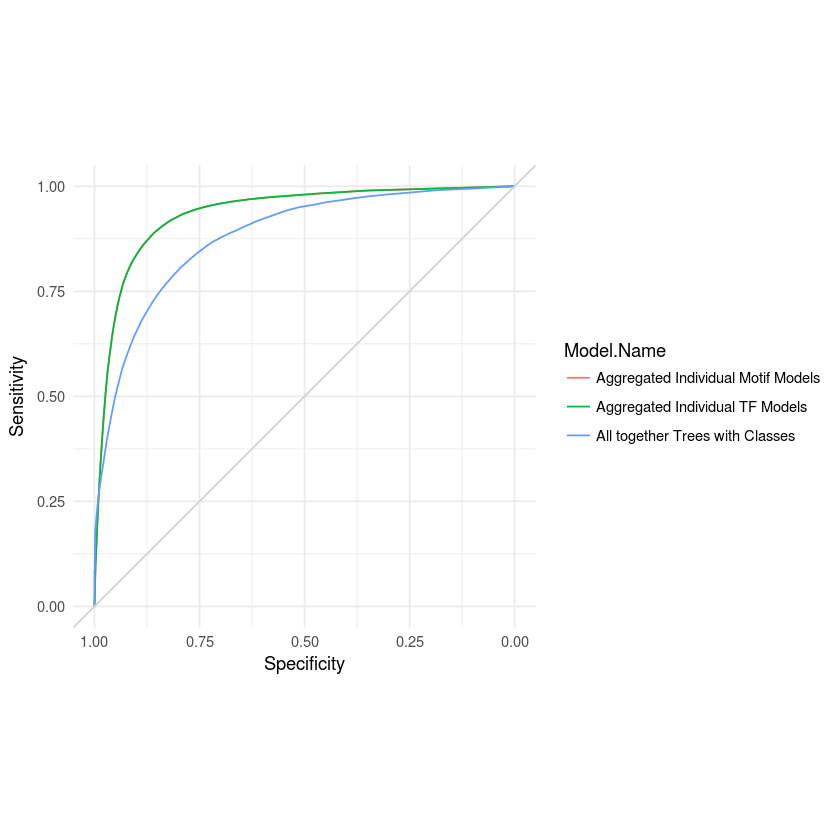

In [62]:
plot.roc.curve(compare_methods_df)

Warning message:
“Removed 69 rows containing missing values (geom_path).”

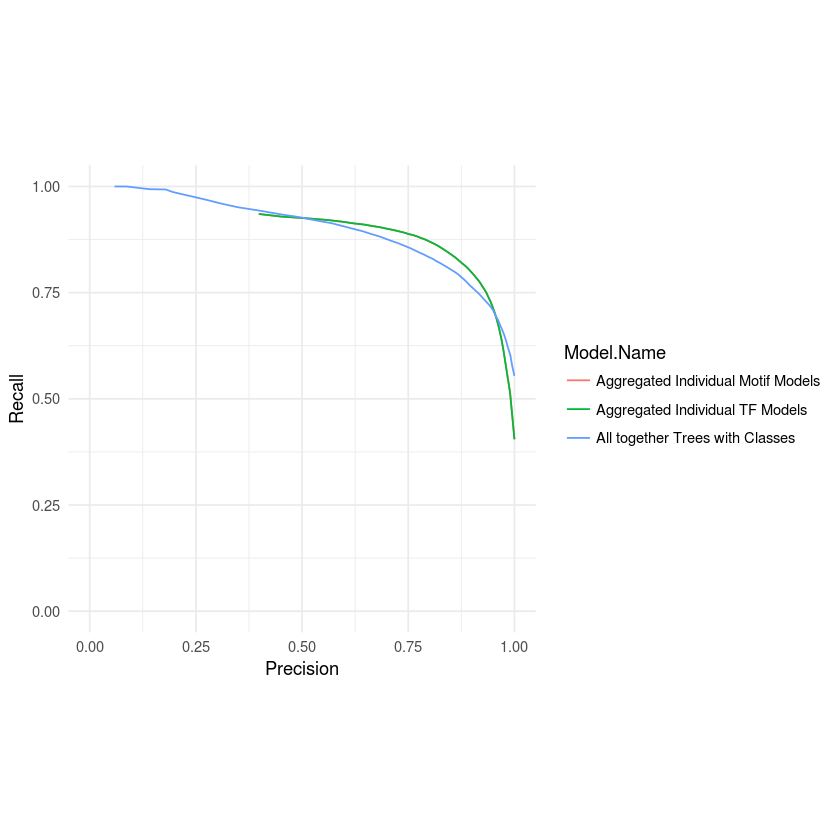

In [63]:
plot.precrecall.curve(compare_methods_df)